In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
file_ground_truth = '/content/drive/MyDrive/690F.csv'
file_test_eval = '/content/drive/MyDrive/test_eval - test_eval.csv.csv'

In [ ]:
# Reading the CSV files
df_ground_truth = pd.read_csv(file_ground_truth, encoding='latin1')
df_test_eval = pd.read_csv(file_test_eval, encoding='latin1')
df_ground_truth_filtered = df_ground_truth[df_ground_truth['labels'] == 1]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_rouge_n_score(output, reference, n=1):
    """
    Function to calculate Rouge-N score.
    'output' is the generated text, 'reference' is the ground truth.
    'n' is the n-gram length.
    """
    # Function to split text into n-grams
    def ngram(text, n):
        words = text.split()
        return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

    # Generating n-grams for output and reference
    output_ngrams = ngram(output, n)
    reference_ngrams = ngram(reference, n)

    # Counting n-grams
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform([' '.join(output_ngrams), ' '.join(reference_ngrams)])

    # Calculating cosine similarity
    cosine_sim = cosine_similarity(count_matrix[0:1], count_matrix[1:2])

    return cosine_sim[0][0]

def calculate_average_rouge_scores(dataframe, model_column, reference_column):
    """
    Function to calculate average Rouge scores for a dataset.
    'dataframe' is the input DataFrame.
    'model_column' is the column containing the model outputs.
    'reference_column' is the column containing the reference (ground truth) texts.
    """
    rouge_1_scores = []
    rouge_2_scores = []

    for index, row in dataframe.iterrows():
        output = row[model_column].strip()
        reference = row[reference_column].strip()

        rouge_1_score = calculate_rouge_n_score(output, reference, n=1)

        rouge_1_scores.append(rouge_1_score)

    # Calculating average Rouge scores
    avg_rouge_1 = np.mean(rouge_1_scores)

    return avg_rouge_1

# Calculating average Rouge scores for Mistral model and GPT-4 model
avg_rouge_scores_mistral = calculate_average_rouge_scores(df_test_eval, 'Mistral_Output', 'question')
avg_rouge_scores_gpt4 = calculate_average_rouge_scores(df_ground_truth_filtered, 'CHATGPT ANSWERS', 'human_ref_B')

avg_rouge_scores_mistral, avg_rouge_scores_gpt4

(0.505592816758098, 0.2938393781231612)

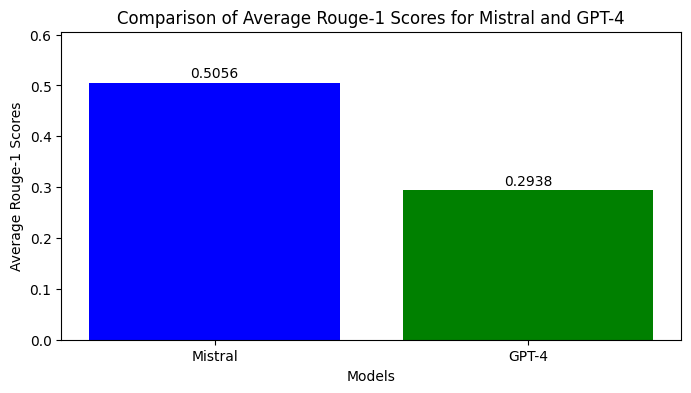

In [ ]:
import matplotlib.pyplot as plt

avg_rouge_1_scores = {
    'Models': ['Mistral', 'GPT-4'],
    'Rouge-1': [avg_rouge_scores_mistral, avg_rouge_scores_gpt4]
}

# Plotting the bar chart
plt.figure(figsize=(8, 4))
plt.bar(avg_rouge_1_scores['Models'], avg_rouge_1_scores['Rouge-1'], color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Average Rouge-1 Scores')
plt.title('Comparison of Average Rouge-1 Scores for Mistral and GPT-4')
plt.ylim(0, max(avg_rouge_1_scores['Rouge-1']) + 0.1)  # Setting y-limit for better visualization
for i, score in enumerate(avg_rouge_1_scores['Rouge-1']):
    plt.text(i, score + 0.01, f'{score:.4f}', ha='center')  # Adding score labels on bars
plt.show()


In [ ]:
# Human EVl vs Mistral
df_test_eval['Rouge-1 Score Mistral'] = df_test_eval.apply(
    lambda row: calculate_rouge_n_score(row['Mistral_Output'], row['question'], n=1), axis=1)

# Extracting the Rouge-1 scores for Mistral model
rouge_1_scores_mistral = df_test_eval['Rouge-1 Score Mistral'].values

rouge_1_scores_mistral


array([0.13155617, 0.41274494, 0.57293074, 0.5855171 , 0.60674195,
       0.32313216, 0.43774465, 0.27529888, 0.33743462, 0.58856051,
       0.50706955, 0.54631299, 0.53973237, 0.42281689, 0.57372797,
       0.38954013, 0.51006137, 0.71076524, 0.50799879, 0.60774438,
       0.99497581, 0.4955762 , 0.53391223, 0.65240555, 0.60727994,
       0.58858186, 0.49067282, 0.78009326, 0.72601077, 0.24856538,
       0.77205411, 0.3478283 , 0.39052199, 0.97582018, 0.23992892,
       0.36248071, 0.79908707, 0.30567932, 0.26026238, 0.36108279,
       0.20905446])

In [ ]:
# Calculating the average Rouge-1 score for the Mistral model
avg_rouge_1_score_mistral = rouge_1_scores_mistral.mean()
avg_rouge_1_score_mistral

0.505592816758098

<ipython-input-27-4cad553495ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ground_truth_filtered['Similar Words GPT-4'] = df_ground_truth_filtered.apply(


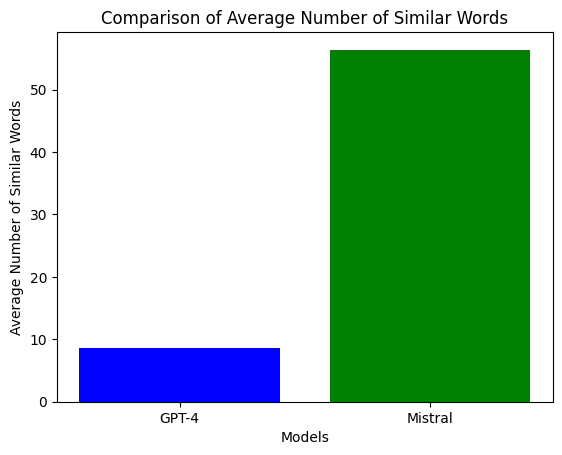

(8.63013698630137, 56.390243902439025)

In [ ]:
def count_similar_words(text1, text2):
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    return len(words1.intersection(words2))

# Applying the function to count similar words for each pair of outputs and ground truths
df_ground_truth_filtered['Similar Words GPT-4'] = df_ground_truth_filtered.apply(
    lambda row: count_similar_words(row['CHATGPT ANSWERS'], row['human_ref_B']), axis=1)
df_test_eval['Similar Words Mistral'] = df_test_eval.apply(
    lambda row: count_similar_words(row['Mistral_Output'], row['question']), axis=1)

# Calculating the average number of similar words
avg_similar_words_gpt4 = df_ground_truth_filtered['Similar Words GPT-4'].mean()
avg_similar_words_mistral = df_test_eval['Similar Words Mistral'].mean()

# Creating a bar chart to visualize the average number of similar words
fig, ax = plt.subplots()

# Bar data
models = ['GPT-4', 'Mistral']
avg_similar_words = [avg_similar_words_gpt4, avg_similar_words_mistral]

# Plotting
ax.bar(models, avg_similar_words, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Average Number of Similar Words')
plt.title('Comparison of Average Number of Similar Words')

plt.show()

avg_similar_words_gpt4, avg_similar_words_mistral